# A Guide to Weighted Averages with Currency Conversions  

Consider the following situation:

* A vendor sets the price for their wares at...
    * `10.00` USD per unit for 9 or fewer units,
    * `9.50` USD per unit for 10-99 units, and
    * `8.00` USD per unit for 100+ units.
* Another vendor sets their price at...
    * `8.00` GBP per unit for 49 or fewer units, and
    * `6.00` GBP per unit for 50+ units.

Or how about a person who travels regularly for business, and needs to track their average nightly cost?  Hotels in each location will vary by price and currency.  How would we determine the weighted averages here? How would we compute the grand total?

Consider the following example for a traveling salesperson.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=currency-conv-with-weighted-ave" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
import pandas as pd
import atoti as tt

session = tt.Session.start()
hotelcost = session.read_pandas(
    pd.DataFrame(
        columns=["Date", "Duration", "Currency", "Cost"],
        data=[
            ("2019-01-15", 4, "EUR", 1400.00),
            ("2019-02-15", 2, "EUR", 320.00),
            ("2019-03-15", 4, "GBP", 1100.00),
            ("2019-04-15", 2, "USD", 400.00),
            ("2019-05-15", 1, "GBP", 302.00),
            ("2019-06-15", 3, "GBP", 800.00),
            ("2019-07-15", 9, "USD", 1100.00),
            ("2019-08-15", 1, "USD", 120.00),
        ],
    ),
    table_name="hotels",
    keys=["Date"],
)

hotelcost.head()

,Duration,Currency,Cost
Date,,,
2019-01-15,4,EUR,1400.0
2019-02-15,2,EUR,320.0
2019-03-15,4,GBP,1100.0
2019-04-15,2,USD,400.0
2019-05-15,1,GBP,302.0


In this example a person traveled montly to several locations, and incurred the cost as listed in the last collumn.  Each stay was a different duration.  Let's create our cube from here.

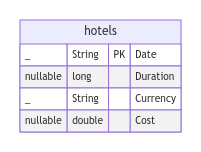

In [2]:
cube = session.create_cube(hotelcost, mode="auto")
h, l, m = cube.hierarchies, cube.levels, cube.measures

session.tables.schema

Let's create a quick pivot table to see what measures we have and what they look like.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
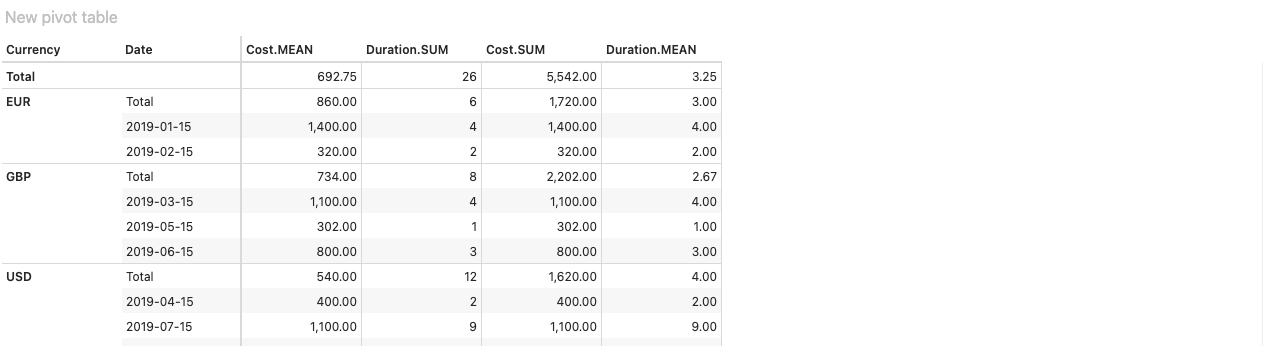

In [3]:
session.widget

Some of these measures are more sensible than others, and some of these grand totals are more sensible than others.

For example: `Duration.SUM` and `Duration.MEAN` are perfectly valid measures, and their grand total values make sense. We know that our traveling salesperson spent 26 nights total in hotels, with an average stay of just about 3 nights per stay.  GBP and USD are currencies only used in one country respectively, so we can even infer this salesperson stayed 8 nights in the UK and 12 in the US.

`Cost.SUM` is a perfectly fine measure up to the currency subtotal-this person's hotel costs were over 1700EUR, 2200GBP and 1600USD, but this doesn't make sense at the grand total level. `Cost.MEAN` ignores the length of stay, and would be better as a weighted average, accounting for the duration.

Let's create a few new measures to clean this up.  Let's start with calculating the cost per each night.

In [4]:
m["NightlyCost"] = tt.where(~l["Date"].isnull(), m["Cost.SUM"] / m["Duration.SUM"])

Looking at this in our pivot table, this seems sensible.  It would not make sense to sum up the unit cost for the same item across two orders.  At best, it might make sense to compute the average at the subtotal.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
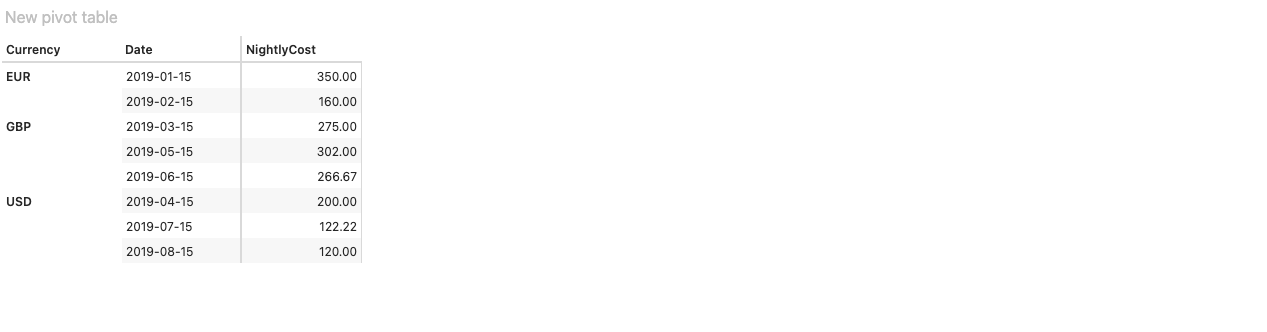

In [5]:
session.widget

While summing up the Nightly Cost may not make sense, it does make sense per each currency to determine the average cost.

In [6]:
m["NightlyCost.MEAN"] = tt.agg.mean(
    m["NightlyCost"], scope=tt.OriginScope(levels={l["Currency"], l["Date"]})
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
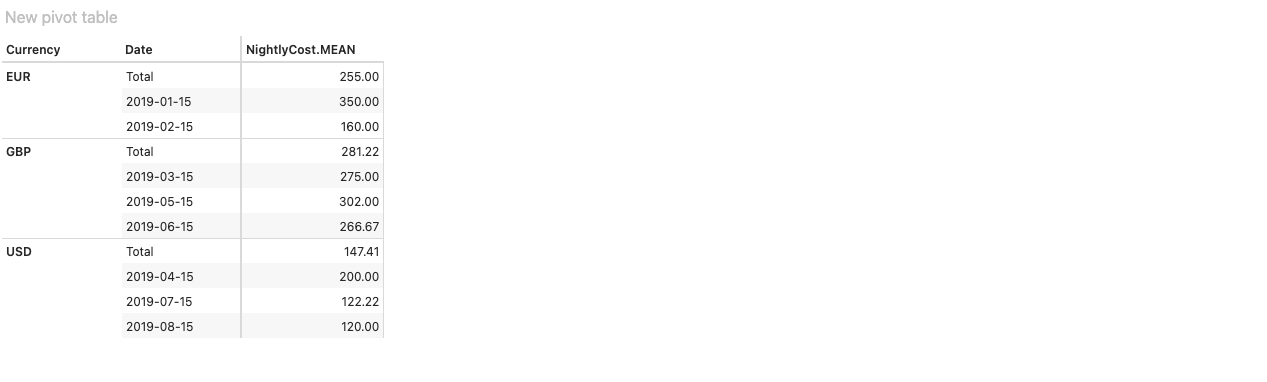

In [7]:
session.widget

While we know the average nightly cost, what about the weighted average nightly cost?  For example, the January trip in the EU had a very expensive nightly cost, while the February trip had a much less expensive nightly cost.

In [8]:
m["NightlyCost.WA"] = tt.agg.sum(
    (m["Cost.SUM"] / m["Duration.SUM"]), scope=tt.OriginScope(levels={l["Currency"]})
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
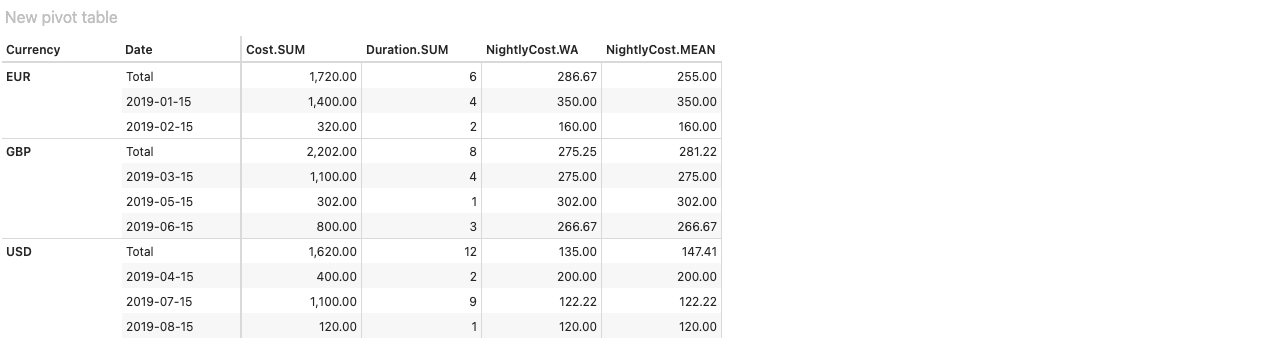

In [9]:
session.widget

We see the average cost per night for our salesperson's hotel expenditure is actually over 280 EUR, and not the 255 EUR from the simple average of nightly cost. Now, how do we determine the actual cost of these trips.  For this, we need to know where the salesperson is located, and use a currency conversion table to compute the cost of each stay in a base currency.

Let's assume the salesperson is located in the United States.

In [10]:
usd_conv = session.read_pandas(
    pd.DataFrame(
        columns=["From", "To", "Rate"],
        data=[
            ("USD", "USD", 1.0000),
            ("CAD", "USD", 0.7768),
            ("EUR", "USD", 1.1282),
            ("GBP", "USD", 1.3319),
        ],
    ),
    table_name="ccy_conv",
    keys=["From"],
)

We can join this to our hotel costs and create new measures from there.

In [11]:
hotelcost.join(usd_conv, hotelcost["Currency"] == usd_conv["From"])

In [12]:
m["Rate"] = tt.agg.single_value(usd_conv["Rate"])
m["AmtUSD"] = tt.agg.sum(
    m["Cost.SUM"] * m["Rate"], scope=tt.OriginScope(levels={l["Date"]})
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
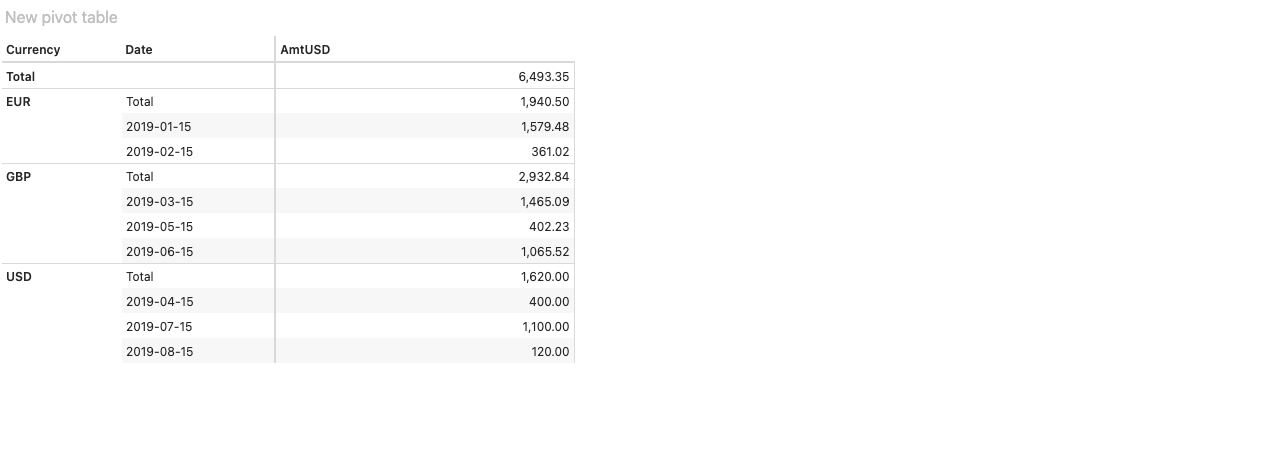

In [13]:
session.widget

And we can also apply this conversion to our nightly costs and weighted average.

In [14]:
m["NightlyCostUSD"] = m["NightlyCost"] * m["Rate"]
m["NightlyCostUSD.WA"] = m["NightlyCost.WA"] * m["Rate"]

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
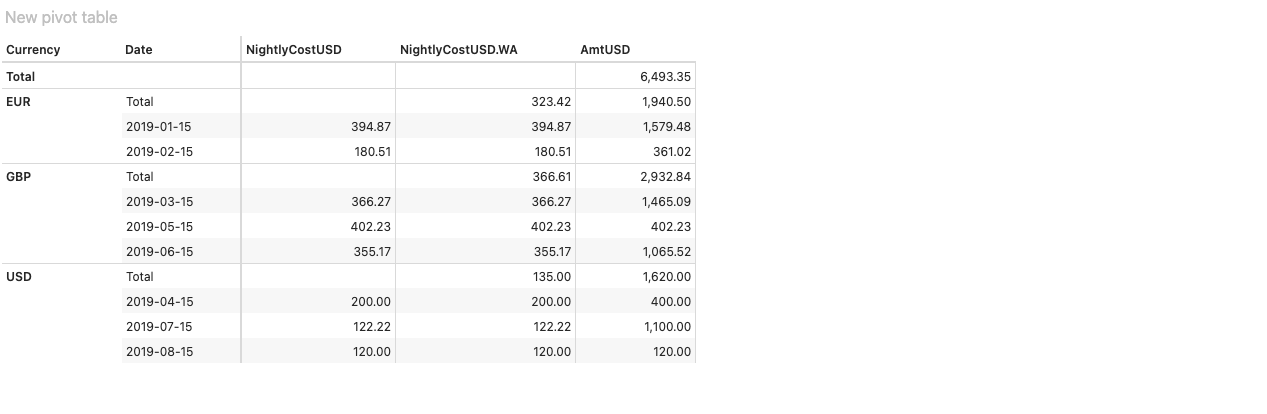

In [15]:
session.widget

We hope you enjoyed this explainer.  Check out our [weighted average example](../weighted-averages/main.ipynb) and our [currency conversion example](../currency-conversion/main.ipynb).

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=currency-conv-with-weighted-ave" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>